# Classifying the Risk Intensity Level for Maternal Mortality during Pregnancy
#### Raychal Ng, Aniket Chakraborty, Hamrah R, Revanda Ghassan R

## Introduction

This dataset presents six factors that affect maternal mortality: age; systolic BP ( pressure in the arteries when the heart beats in mmHg); diastolic BP (pressure in the arteries during rests between beats in mmHg); blood sugar (blood glucose level in mmol/L), body temperature (in Fahrenheit), and heart rate in beats per minute. Deviation from normal levels in these factors contributes to maternal mortality. The data was obtained from different hospitals and clinics in Bangladesh. It was collected using the loT-based risk monitoring system which contains data from mechanical and digital machines used on patients. The risk level for mortality was classified for 1014 pregnancies based on midwifery assessments. 

#### Predictive Question
We aim to answer the question: Can we reliably predict maternal mortality in the future based on data collected during patient admission, i.e. age, systolic BP, diastolic BP and blood sugar.

## Methods & Results

### Preliminary Exploratory Data Analysis

In [16]:
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(RColorBrewer)

In [25]:
maternal_health_dataset <- read_csv("https://raw.githubusercontent.com/aniketc12/maternal_risk/main/data/maternal_health_risk.csv") 
maternal_health_dataset <- maternal_health_dataset |>
    mutate(RiskLevel =as_factor(RiskLevel)) #the RiskLevel was mutated to be a factor instead of a character input
colnames(maternal_health_dataset) <- c("Age", "SystolicBP", "DiastolicBP", "BloodSugar", "BodyTemp", "HeartRate", "RiskLevel") #all column names remained the same, except "BS" was changed to "BloodSugar" for readability

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [18]:
set.seed(1) #seed was set to ensure reproducibility of code 
maternal_health_dataset <- maternal_health_dataset |>
    select(!c("BodyTemp", "HeartRate")) #select for all columns except BodyTemp and HeartRate as these were not a part of our chosen variables (discussed in graphs 1-4) 
maternal_split <- initial_split(maternal_health_dataset, prop = 0.75, strata = RiskLevel) #the dataset was split into a training and testing set with 75% of the data being allocated to the training set
training_set <- training(maternal_split) #the training set will be used for building the classifier
testing_set <- testing(maternal_split) #the testing set will be saved until the end to test the accuracy of the classifier

#### Graphs 1 to 4: Distribution of Chosen Variables in Each Risk Level for Maternal Mortality

Graphs 1 to 4 show the distribution of each chosen variable across each risk level using overlaid density graphs. The risk levels for maternal mortality were visualized using different colors. 

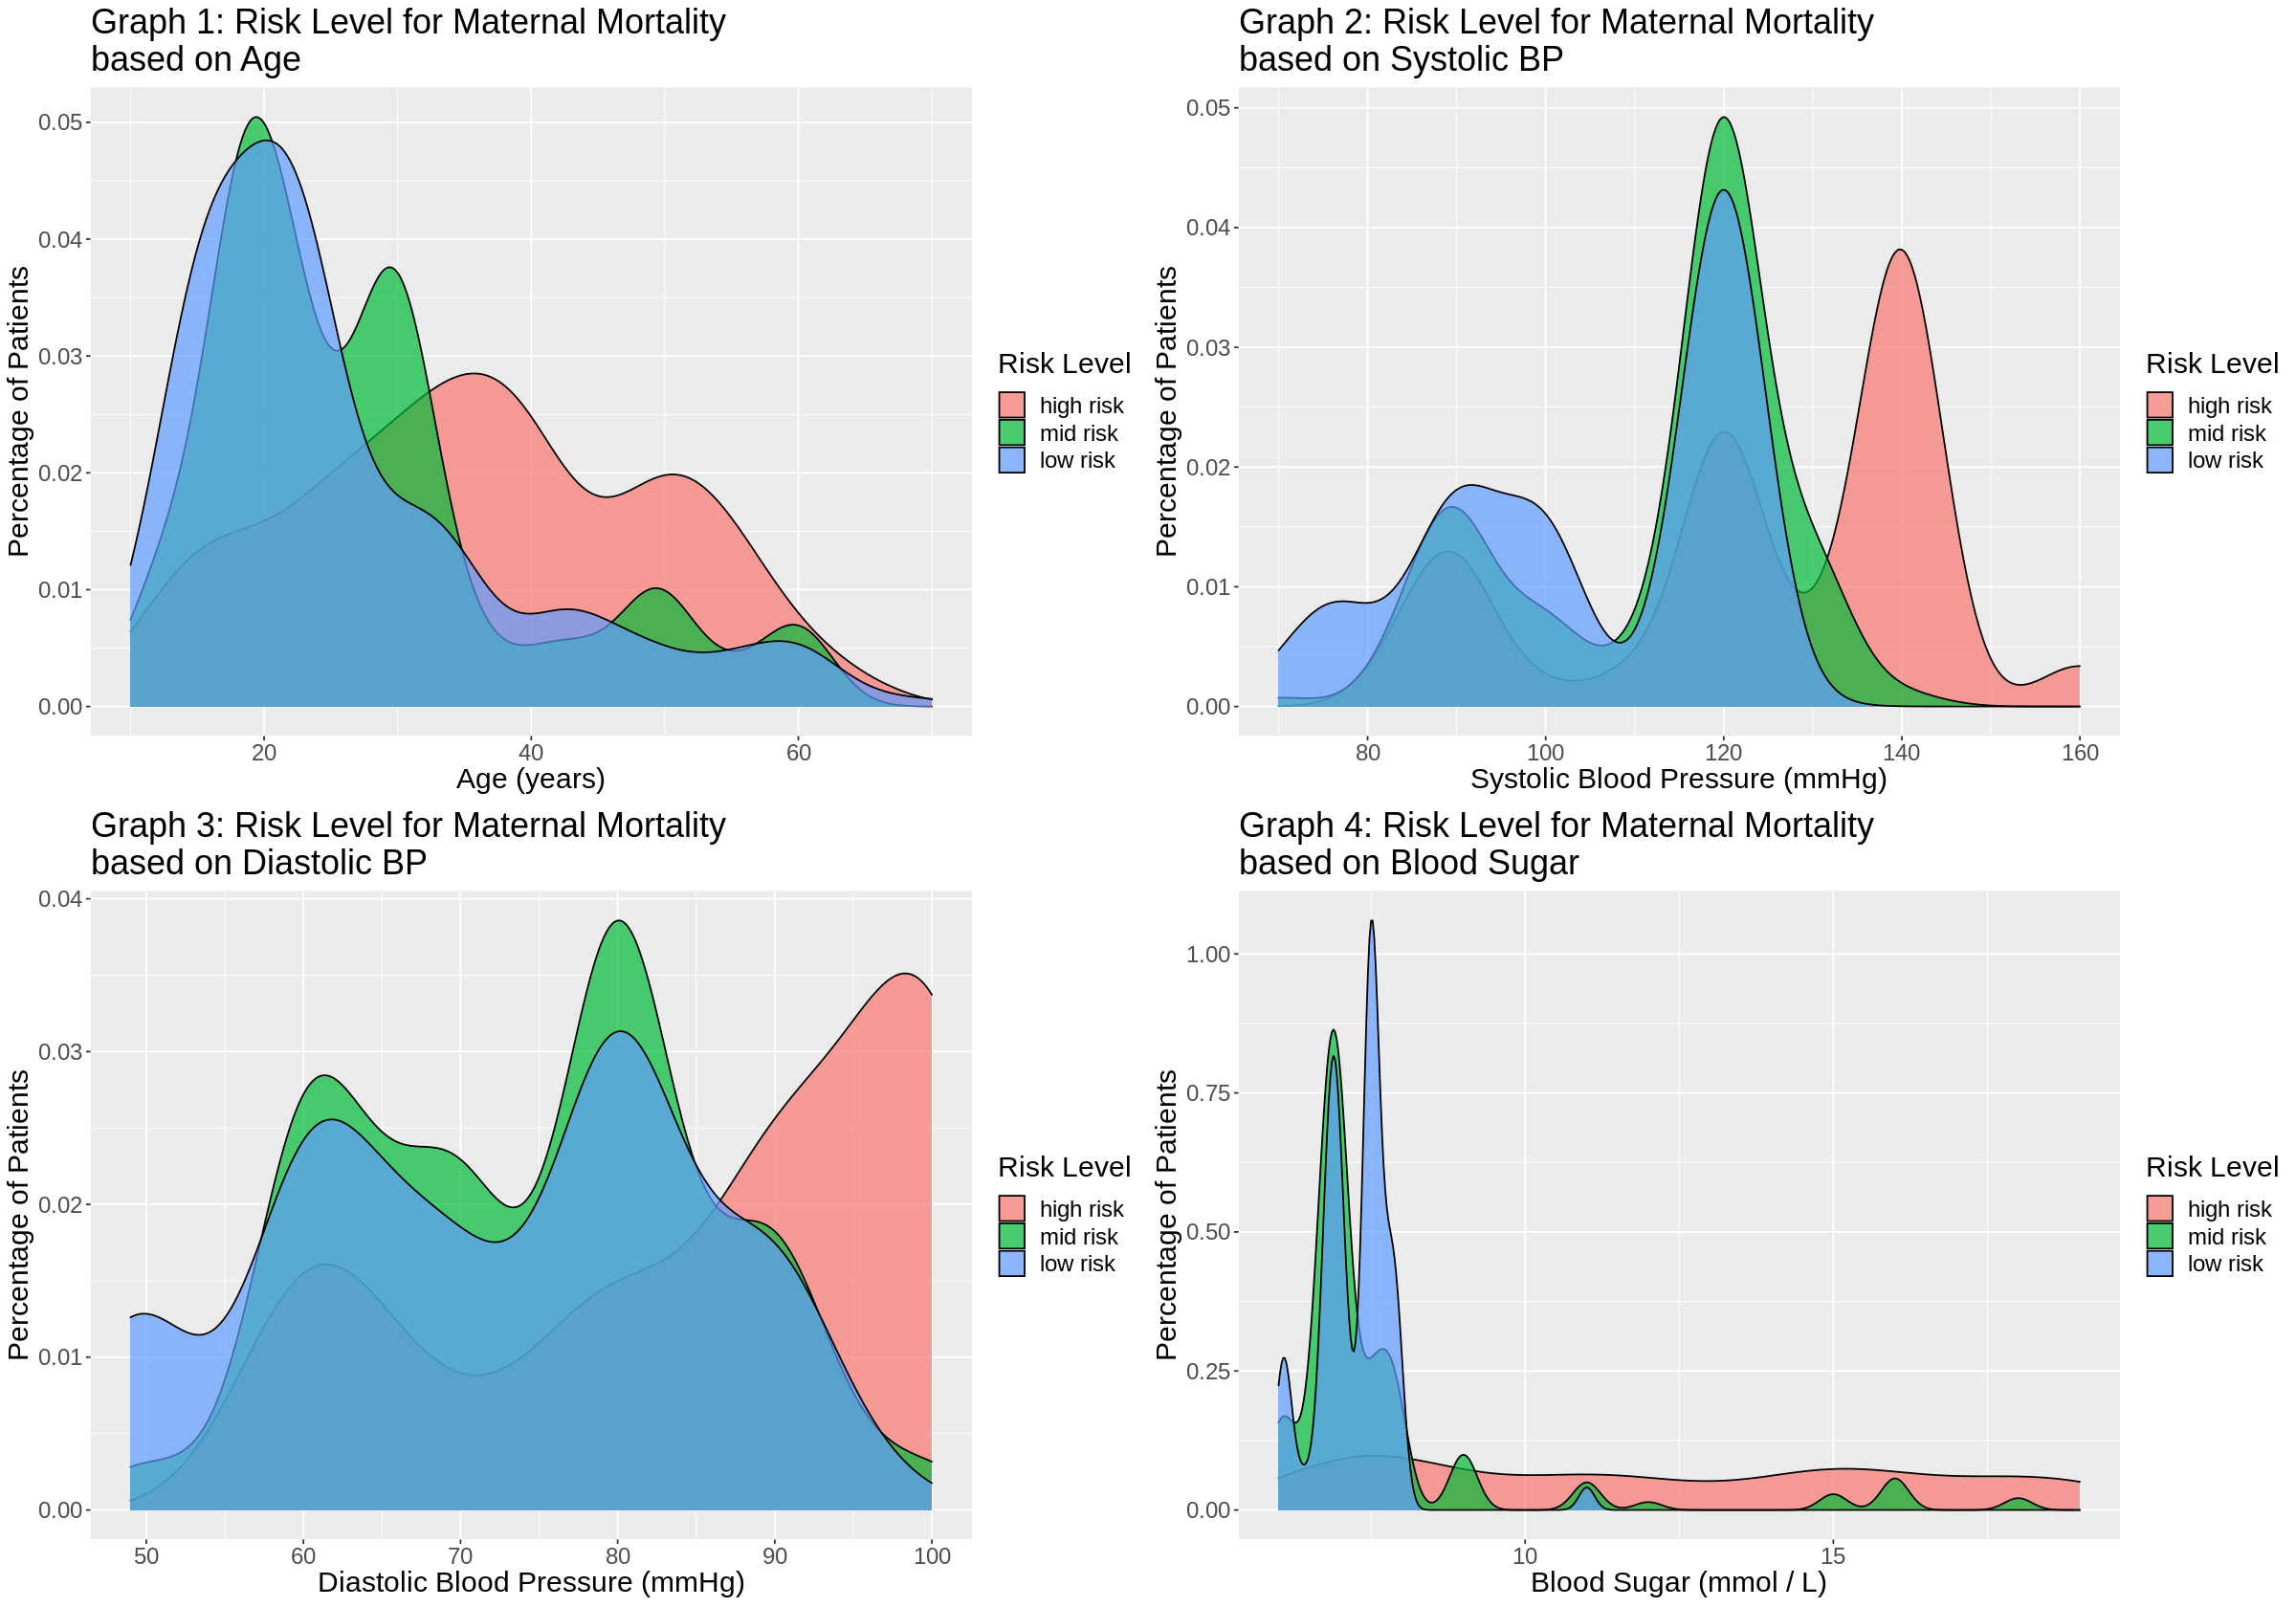

In [19]:
alpha <- 0.7 #alpha set to 0.7 to allow for slight transparency in the three plotted distributions
age_histogram <-  ggplot(training_set, aes(x = Age)) + #distribution of the ages present in each risk level was visualized in a density plot
geom_density(aes(fill = factor(RiskLevel, levels = c("high risk", "mid risk", "low risk"))), alpha=alpha) + #the density plots were colored based on risk level and the levels were set to order them from high risk to low risk for readability
labs(x = "Age (years)", y = "Percentage of Patients", fill = "Risk Level") +
theme(text = element_text(size = 18)) +
ggtitle("Graph 1: Risk Level for Maternal Mortality \nbased on Age")


systolic_histogram <-  ggplot(training_set, aes(x = SystolicBP)) + #same process as above was conducted, but for the distribution of Systolic BP
geom_density(aes(fill = factor(RiskLevel, levels = c("high risk", "mid risk", "low risk"))), alpha=alpha) +
labs(x = "Systolic Blood Pressure (mmHg)", y = "Percentage of Patients", fill = "Risk Level") +
theme(text = element_text(size = 18)) +
ggtitle("Graph 2: Risk Level for Maternal Mortality \nbased on Systolic BP")

diastolic_histogram <-  ggplot(training_set, aes(x = DiastolicBP)) + #same process as above was conducted, but for the distribution of Distolic BP
geom_density(aes(fill = factor(RiskLevel, levels = c("high risk", "mid risk", "low risk"))), alpha=alpha) +
labs(x = "Diastolic Blood Pressure (mmHg)", y = "Percentage of Patients", fill = "Risk Level") +
theme(text = element_text(size = 18)) +
ggtitle("Graph 3: Risk Level for Maternal Mortality \nbased on Diastolic BP")

bs_histogram <- ggplot(training_set, aes(x = BloodSugar)) + #same process as above was conducted, but for the distribution of Blood Sugar
geom_density(aes(fill = factor(RiskLevel, levels = c("high risk", "mid risk", "low risk"))), alpha=alpha) +
labs(x = "Blood Sugar (mmol / L)", y = "Percentage of Patients", fill = "Risk Level") +
theme(text = element_text(size = 18)) +
ggtitle("Graph 4: Risk Level for Maternal Mortality \nbased on Blood Sugar")

options(repr.plot.height = 14, repr.plot.width = 20) 
grid.arrange(age_histogram, systolic_histogram, diastolic_histogram, bs_histogram, nrow = 2) #the graphs were arranged into a grid containing 2 graphs per row for ease of visualizing the density plots

explain the graphs

In addition to the correlations observed between the risk level for maternal mortality and each variable, a literature search was conducted to find supporting evidence for our choice of variables (age, systolic BP, diastolic BP, and blood sugar) that will be used in the classification model. Studies suggest that maternal age increases the risk of several complications relating to the process of childbirth/maternal mortality, including gestational diabetes, hypertension, and pre-eclampsia. Thus, maternal age influences the maternal mortality risk during pregnancy. Furthermore, research shows that between 2010-2012 almost 30% of maternal deaths happened between women ages ranging 30-39 years[1]. Similarly, studies conducted by Boyd et al. investigated patterns of blood pressure in pregnant women, and concluded that women with higher levels of diastolic and systolic blood pressure during their first trimester of pregnancy are at a higher risk of developing hypertensive disorders in pregnancy(HDP)[2]. HDP can lead to increased risk of maternal mortality as well as impact the child’s blood pressure after birth. Blood sugar is our fourth variable. Diabetes is a sign of high blood sugar, and this dysregulation of blood sugar poses a severe risk for maternal mortality, affecting one in six pregnancies around the world[3]. Usually during pregnancies, hemoglobin A1c, which measures the average blood glucose concentration) is tested. In a study conducted by Davidson et al., they found that the rise in hemoglobin A1c correlates to a higher risk in maternal mortality[4]. Body temperature and heart rate were the other two variables included in the original dataset but were not chosen to be used in building our classifier. Most studies that evaluate the relationship between body temperature or heart rate with pregnancies showed a correlation with effects on only the fetus, but not maternal mortality itself. Therefore, the “heart-rate” and “temperature” variable was omitted from the classification model. 

#### Table 1: Number of Observations in Each Maternal Mortality Risk Level 

In Table 1, the distribution of the three risk levels for maternal mortality in the training data was tabulated to determine the spread of data across the classes. The training data was grouped by the three risk levels for maternal mortality and then the number of observations in each group was summarized. 

In [20]:
risk_distribution <- training_set |>
group_by(RiskLevel) |> #group the training data into 3 groups based on their risk Level 
summarize(n=n()) #calculate the number of observations of each risk level
risk_distribution

RiskLevel,n
<fct>,<int>
high risk,204
low risk,304
mid risk,252


As the number of observations in each class is relatively equal (204-304), no further balancing of data is needed and we can proceed with building the classifier.  

#### Table 2: Tabulation of the Total Number of ‘NA’ values in the Training Data 

In [21]:
na <- tibble(number_of_na_values = sum(is.na(training_set))) #a count of the total NA values present in training set was summed 
na

number_of_na_values
<int>
0


In table 2, the total number of NA values across the training set was summed to determine if there was any missing data in the observations.  However, none of the observations contain an NA value so no special wrangling of data is required and all observations can be used to build the classifier. 

#### Tables 3 to 5: Range of Variables in Each Risk Level

Tables 3 to 5 shows the range (max and min) of the four chosen variables (age, systolic BP, diastolic BP, and blood sugar) for high, mid and low risk pregnancies, respectively. There is a wide range of data for each class and the max and min of the four variables do not differ drastically between the classes.

#### Table 3: Max and Minimum Values of the Variables in High Risk Pregnancies

In [22]:
min_vals_high <- training_set |>
    filter(RiskLevel == "high risk") |> #the dataset was filtered to only show observations from the high risk class
    select(!RiskLevel) |> #all columns except the 'RiskLevel' variable was selected for as we already know all observations are from the high risk level
    map_df(min) #the minimum value of each variable was determined

max_vals_high <- training_set |>
    filter(RiskLevel == "high risk") |>
    select(!RiskLevel) |>
    map_df(max) #the maximum value of each variable was determined

high_risk_variable_range <- full_join(min_vals_high, max_vals_high) #the maximum and minimum values determined from above were joined into one table

high_risk_variable_range

Joining, by = c("Age", "SystolicBP", "DiastolicBP", "BloodSugar")


Age,SystolicBP,DiastolicBP,BloodSugar
<dbl>,<dbl>,<dbl>,<dbl>
12,83,60,6.1
65,160,100,19.0


Table 3 shows the range of each variable for pregnancies categorized as high risk: the age ranged from 12-65 years old, the Systolic BP ranged from 83-160 mmHg, the Diastolic BP ranged from 60-100 mmHg, and the blood sugar ranged from 6.1-19.0 mmol/L.

#### Table 4: Max and Minimum Values of the Variables in Mid Risk Pregnancies

In [23]:
min_vals_mid <- training_set |>
    filter(RiskLevel == "mid risk") |> #same process as table 3 was used, but filtered for the 'mid risk' level of maternal mortality instead
    select(!RiskLevel) |>
    map_df(min)

max_vals_mid <- training_set |>
    filter(RiskLevel == "mid risk") |>
    select(!RiskLevel) |>
    map_df(max)

mid_risk_variable_range <- full_join(min_vals_mid, max_vals_mid)

mid_risk_variable_range


Joining, by = c("Age", "SystolicBP", "DiastolicBP", "BloodSugar")


Age,SystolicBP,DiastolicBP,BloodSugar
<dbl>,<dbl>,<dbl>,<dbl>
10,70,50,6
60,140,100,18


Table 4 shows the range of each variable for pregnancies categorized as mid risk: the age ranged from 10-60 years old, the Systolic BP ranged from 70-140 mmHg, the Diastolic BP ranged from 50-100 mmHg, and the blood sugar ranged from 6-18 mmol/L.

#### Table 5: Max and Minimum Values of the Variables in High Risk Pregnancies

In [24]:
min_vals_low <- training_set |>
    filter(RiskLevel == "low risk") |> #same process as above, but for the low risk pregnancies 
    select(!RiskLevel) |>
    map_df(min) 

max_vals_low <- training_set |>
    filter(RiskLevel == "low risk") |>
    select(!RiskLevel) |>
    map_df(max)

low_risk_variable_range <- full_join(min_vals_low, max_vals_low)

low_risk_variable_range

Joining, by = c("Age", "SystolicBP", "DiastolicBP", "BloodSugar")


Age,SystolicBP,DiastolicBP,BloodSugar
<dbl>,<dbl>,<dbl>,<dbl>
10,70,49,6
70,129,100,11


Table 5 shows the range of each variable for pregnancies categorized as low risk: the age ranged from 10-70 years old, the Systolic BP ranged from 70-129 mmHg, the Diastolic BP ranged from 49-100 mmHg, and the blood sugar ranged from 6-11 mmol/L.

### Data Analysis